In [ ]:
!wget https://www.openslr.org/resources/12/train-clean-100.tar.gz
!tar -xzf train-clean-100.tar.gz
!rm train-clean-100.tar.gz
!ls LibriSpeech/train-clean-100/

--2025-03-31 07:52:17--  https://www.openslr.org/resources/12/train-clean-100.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://openslr.elda.org/resources/12/train-clean-100.tar.gz [following]
--2025-03-31 07:52:18--  https://openslr.elda.org/resources/12/train-clean-100.tar.gz
Resolving openslr.elda.org (openslr.elda.org)... 141.94.109.138, 2001:41d0:203:ad8a::
Connecting to openslr.elda.org (openslr.elda.org)|141.94.109.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6387309499 (5.9G) [application/x-gzip]
Saving to: ‘train-clean-100.tar.gz’

train-clean-100.tar 100%[===================>]   5.95G  9.06MB/s    in 7m 33s  

2025-03-31 07:59:52 (13.5 MB/s) - ‘train-clean-100.tar.gz’ saved [6387309499/6387309499]

103   1363  19	  2196	27    3168  3664  405	4441  5049  5750  6272	696   7447  810

In [ ]:
import os
import numpy as np
import librosa
from tqdm import tqdm

# Constants matching your C implementation
SAMPLE_RATE = 16000
FRAME_SIZE = 512
HOP_LENGTH = 384
N_FFT = 512
N_MELS = 40
PRE_EMPHASIS_COEFF = 0.96785  # From your C code

def load_metadata(input_dir):
    """Load both speaker and chapter metadata"""
    # Load speaker info
    speaker_info = {}
    speaker_file = os.path.join(input_dir, "..", "speaker.txt")  # One level up from train-clean-100
    if os.path.exists(speaker_file):
        with open(speaker_file, 'r') as f:
            for line in f:
                if line.strip():
                    parts = [p.strip() for p in line.split('|')]
                    speaker_id = parts[0]
                    speaker_info[speaker_id] = {
                        'sex': parts[1],
                        'subset': parts[2],
                        'minutes': float(parts[3]),
                        'name': parts[4]
                    }

    # Load chapter info
    chapter_info = {}
    chapter_file = os.path.join(input_dir, "..", "chapters.txt")  # One level up from train-clean-100
    if os.path.exists(chapter_file):
        with open(chapter_file, 'r') as f:
            for line in f:
                if line.strip():
                    parts = [p.strip() for p in line.split('|')]
                    chapter_id = parts[0]
                    chapter_info[chapter_id] = {
                        'reader': parts[1],
                        'minutes': float(parts[2]),
                        'subset': parts[3],
                        'project_id': parts[4],
                        'book_id': parts[5],
                        'chapter_title': parts[6],
                        'project_title': parts[7]
                    }

    return speaker_info, chapter_info

def apply_pre_emphasis(y, coeff=PRE_EMPHASIS_COEFF):
    """Apply pre-emphasis matching your C implementation"""
    emphasized = np.zeros_like(y, dtype=np.float32)
    emphasized[0] = y[0]
    for i in range(1, len(y)):
        emphasized[i] = y[i] - coeff * y[i-1]
    return emphasized

def apply_re_emphasis(y, coeff=PRE_EMPHASIS_COEFF):
    """Apply inverse of pre-emphasis (re-emphasis)"""
    reemphasized = np.zeros_like(y, dtype=np.float32)
    reemphasized[0] = y[0]
    for i in range(1, len(y)):
        reemphasized[i] = y[i] + coeff * reemphasized[i-1]
    return reemphasized

def extract_mfe_segmented(audio_path, segment_sec=1.0, target_frames=None):
    """Extract 1-second segmented MFEs (pad/truncate to target_frames if specified)"""
    # Load audio
    y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)
    y = y / np.max(np.abs(y))  # Normalize

    # Pre-emphasis
    y_emphasized = apply_pre_emphasis(y)

    # Calculate segmentation
    hop_samples = HOP_LENGTH
    frames_per_segment = int(segment_sec * SAMPLE_RATE / hop_samples)

    # Process in 1-second chunks
    mfe_segments = []
    for start_idx in range(0, len(y_emphasized), SAMPLE_RATE):  # Jump by 1-second intervals
        end_idx = start_idx + SAMPLE_RATE
        if end_idx > len(y_emphasized):
            break  # Discard incomplete segment

        # Extract segment
        segment = y_emphasized[start_idx:end_idx]

        # Compute STFT
        stft = librosa.stft(
            segment,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            win_length=FRAME_SIZE,
            window='hamming'
        )
        spectrogram = np.abs(stft)

        # Convert to dB and normalize
        spectrogram = 10 * np.log10(spectrogram**2 + 1e-20)
        spectrogram = np.maximum(spectrogram, -50)
        spectrogram = (spectrogram + 50) / 62

        # Mel scaling
        mel_basis = librosa.filters.mel(
            sr=SAMPLE_RATE,
            n_fft=N_FFT,
            n_mels=N_MELS,
            fmin=0,
            fmax=8000
        )
        mfe = np.dot(mel_basis, spectrogram)

        # Pad/truncate if target_frames is specified
        if target_frames:
            if mfe.shape[1] < target_frames:
                mfe = np.pad(mfe, ((0, 0), (0, target_frames - mfe.shape[1])))
            else:
                mfe = mfe[:, :target_frames]

        mfe_segments.append(mfe.T)  # Transpose to (time, mel)

    return mfe_segments  # List of (62, 40) arrays (or target_frames if specified)


def process_librispeech_segmented(input_dir, output_path, min_samples=1448, segment_sec=1.0):
    """Process dataset with 1-second segmentation"""
    samples = []
    classes = []
    speaker_info, chapter_info = load_metadata(input_dir)
    speaker_counts = {}

    # First pass: count valid segments per speaker
    print("Counting segments per speaker...")
    for root, _, files in os.walk(input_dir):
        parts = root.split(os.sep)
        if len(parts) >= 3 and parts[-2].isdigit() and parts[-1].isdigit():
            speaker_id = parts[-2]
            for file in files:
                if file.endswith('.flac'):
                    audio_path = os.path.join(root, file)
                    y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)
                    num_segments = int(len(y) / SAMPLE_RATE)  # Full 1-second segments
                    speaker_counts[speaker_id] = speaker_counts.get(speaker_id, 0) + num_segments

    # Filter speakers with enough segments
    valid_speakers = {spk: cnt for spk, cnt in speaker_counts.items() if cnt >= min_samples}
    speaker_ids = {spk: idx for idx, spk in enumerate(sorted(valid_speakers.keys()))}

    print(f"Processing {len(valid_speakers)} speakers with ≥{min_samples} segments...")

    # Second pass: extract segments
    for speaker in tqdm(valid_speakers):
        processed_segments = 0
        speaker_path = os.path.join(input_dir, speaker)

        for root, _, files in os.walk(speaker_path):
            for file in sorted(files):
                if file.endswith('.flac') and processed_segments < min_samples:
                    audio_path = os.path.join(root, file)
                    mfe_segments = extract_mfe_segmented(audio_path, segment_sec=segment_sec)

                    for mfe in mfe_segments:
                        if processed_segments >= min_samples:
                            break
                        samples.append(mfe)
                        classes.append(speaker_ids[speaker])
                        processed_segments += 1

    # Save as NPZ
    samples = np.array(samples, dtype=np.float32)
    classes = np.array(classes, dtype=np.int32)

    np.savez_compressed(
        output_path,
        features=samples,  # Shape: (n_segments, 40, 40)
        speaker_labels=classes
    )
    print(f"Saved {len(samples)} segments (1s each) to {output_path}")


# Run with 1-second segmentation
process_librispeech_segmented(
    input_dir="LibriSpeech/train-clean-100",
    output_path="librispeech-train-100-clean-mfe-1sec.npz",
    min_samples=1448,
    segment_sec=1.0
)

Counting segments per speaker...
Processing 94 speakers with ≥1448 segments...


100%|██████████| 94/94 [25:15<00:00, 16.12s/it]


Saved 136112 segments (1s each) to librispeech-train-100-clean-mfe-1sec.npz


2.18.0
['features', 'speaker_labels']
(136112, 40, 40)
(136112,)
Number of classes: 94
There are 94 classes with more than 1448 samples.
Discarding classes with fewer samples...


<ipython-input-4-14d78425576f>:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  filtered_classes[i] = np.where(counts[0] == filtered_classes[i])[0]


New number of samples in dataset: 136112
Samples for class 0: 1448
Samples for class 1: 1448
Samples for class 2: 1448
Samples for class 3: 1448
Samples for class 4: 1448
Samples for class 5: 1448
Samples for class 6: 1448
Samples for class 7: 1448
Samples for class 8: 1448
Samples for class 9: 1448
Samples for class 10: 1448
Samples for class 11: 1448
Samples for class 12: 1448
Samples for class 13: 1448
Samples for class 14: 1448
Samples for class 15: 1448
Samples for class 16: 1448
Samples for class 17: 1448
Samples for class 18: 1448
Samples for class 19: 1448
Samples for class 20: 1448
Samples for class 21: 1448
Samples for class 22: 1448
Samples for class 23: 1448
Samples for class 24: 1448
Samples for class 25: 1448
Samples for class 26: 1448
Samples for class 27: 1448
Samples for class 28: 1448
Samples for class 29: 1448
Samples for class 30: 1448
Samples for class 31: 1448
Samples for class 32: 1448
Samples for class 33: 1448
Samples for class 34: 1448
Samples for class 35: 14

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "cnn-librispeech-classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 40, 40, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 40, 40, 1)           │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 40, 40, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fully_connected (Dense)              │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 94)                  │          12,126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,410 (271.13 KB)

 Trainable params: 69,408 (271.12 KB)

 Non-trainable params: 2 (8.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
2977/2977 ━━━━━━━━━━━━━━━━━━━━ 98s 32ms/step - accuracy: 0.0349 - loss: 4.3490 - val_accuracy: 0.1926 - val_loss: 3.2680
Epoch 2/300
2977/2977 ━━━━━━━━━━━━━━━━━━━━ 94s 32ms/step - accuracy: 0.1661 - loss: 3.3198 - val_accuracy: 0.3133 - val_loss: 2.6416
Epoch 3/300
2977/2977 ━━━━━━━━━━━━━━━━━━━━ 103s 35ms/step - accuracy: 0.2587 - loss: 2.8020 - val_accuracy: 0.3999 - val_loss: 2.2562
Epoch 4/300
2977/2977 ━━━━━━━━━━━━━━━━━━━━ 99s 33ms/step - accuracy: 0.3337 - loss: 2.4482 - val_accuracy: 0.4634 - val_loss: 1.9804
Epoch 5/300
2977/2977 ━━━━━━━━━━━━━━━━━━━━ 95s 32ms/step - accuracy: 0.3874 - loss: 2.2159 - val_accuracy: 0.5123 - val_loss: 1.7792
Epoch 6/300
2977/2977 ━━━━━━━━━━━━━━━━━━━━ 96s 32ms/step - accuracy: 0.4369 - loss: 2.0076 - val_accuracy: 0.5478 - val_loss: 1.6145
Epoch 7/300
2977/2977 ━━━━━━━━━━━━━━━━━━━━ 95s 32ms/step - accuracy: 0.4783 - loss: 1.8400 - val_accuracy: 0.5826 - val_loss: 1.4769
Epoch 8/300
2977/2977 ━━━━━━━━━━━━━━━━━━━━ 94s 32ms/step - accuracy:

Model: "d-vector-extractor-256"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 40, 40, 1)           │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 40, 40, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,388 (95.27 KB)

 Trainable params: 24,386 (95.26 KB)

 Non-trainable params: 2 (8.00 B)

Saved artifact at '/tmp/tmpl6akw0qd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40, 40, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 94), dtype=tf.float32, name=None)
Captures:
  133016445889104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133016445886608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133016624322640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133016445888336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133016445887568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133016445888144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133016445887184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133016445891600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133016445893904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133016445879312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133016445890256: Tenso

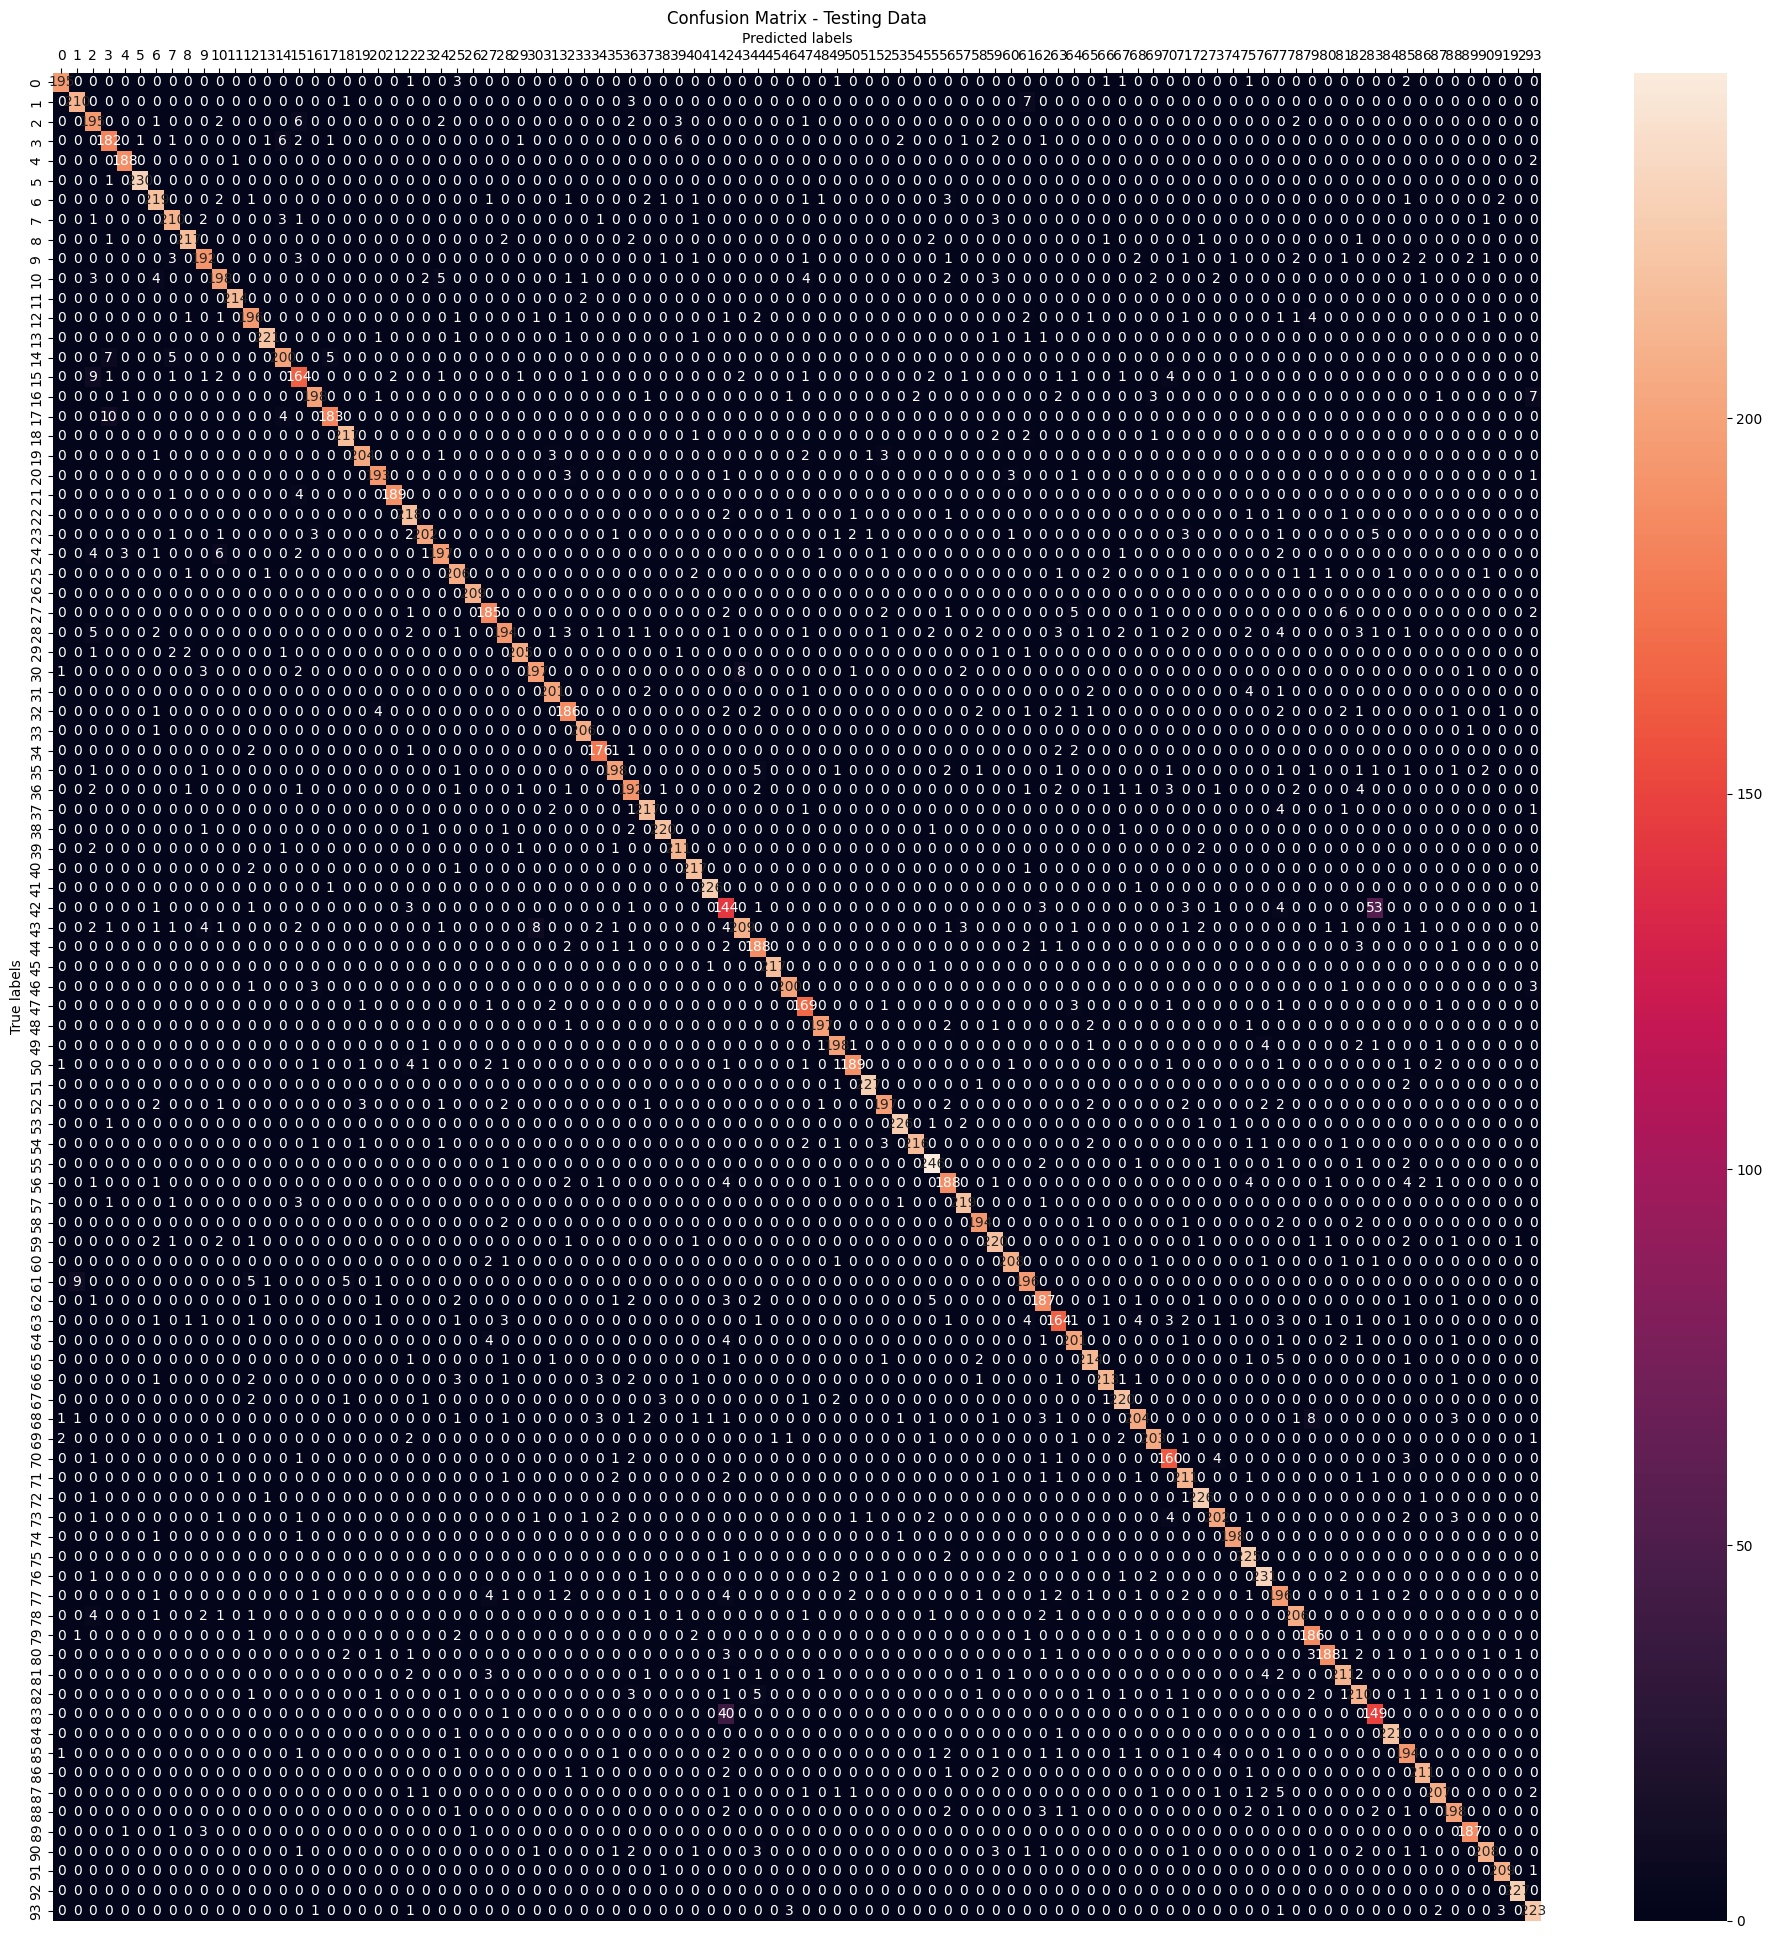

In [4]:
import os
# Set warning suppressions
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import shutil
import numpy as np
import tensorflow as tf
#Matplotlib import
import matplotlib as mpl
import matplotlib.pyplot as plt
#Math import
import math

import subprocess
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

import shutil
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

dataset_path = "librispeech-train-100-clean-mfe-1sec.npz"
dataset = np.load(dataset_path)
print(dataset.files)
# Convert the npz to a dictionary

dataset = dict(dataset)
# Access the data in the dictionary
samples = dataset['features'][:, :40, :]
classes = dataset['speaker_labels'].astype(int)

# Print the shapes of the data arrays
print(samples.shape)
print(classes.shape)

# Find the number of classes
# Find the unique elements in the array
classes_list = np.unique(classes)
classes.astype(int)

# Print the number of unique elements
print("Number of classes: " + str(len(classes_list)))

# Count the number of samples for each class
counts = np.unique(classes, return_counts=True)[1]

# Filter out the classes with fewer samples
threshold = 1448  # Keep only classes with at least 1455 samples
keep_classes = np.where(counts >= threshold)[0]

print("There are %d classes with more than %d samples." % (len(keep_classes), threshold))
print("Discarding classes with fewer samples...")

filtered_samples = []
filtered_classes = []

# Filter the samples and labels to include only the samples that belong to the keep_classes
for i in range(0, len(classes)):
  if(classes[i] in keep_classes):
    filtered_samples.append(samples[i])
    filtered_classes.append(classes[i])

filtered_samples = np.array(filtered_samples)
filtered_classes = np.array(filtered_classes)

# Count the number of samples for each remaining class
counts = np.unique(filtered_classes, return_counts=True)

## Last: adapt the numbering of classes from 0 to (number of classes)-1
for i in range(0, len(filtered_classes)):
  filtered_classes[i] = np.where(counts[0] == filtered_classes[i])[0]

# Count the number of samples for each remaining class
counts = np.unique(filtered_classes, return_counts=True)

print("New number of samples in dataset: %d" % (len(filtered_classes)))
for i in range(0, len(keep_classes)):
  print("Samples for class %d: %d" %(counts[0][i], counts[1][i]))

# Free up some memory or Google Colab will crash
del samples
del classes
del dataset

samples = filtered_samples
classes = filtered_classes

import sklearn
from sklearn.model_selection import train_test_split

train_percentage = 0.7
test_percentage = 0.15
val_percentage = 0.15

# Compute the correct percentages to be used in Sklearn Splitting code:
test_percentage = test_percentage + val_percentage
val_percentage = val_percentage / test_percentage

# Split the dataset into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(samples, classes, test_size=test_percentage)

print("Training set:")
print(X_train.shape, y_train.shape)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=val_percentage)

print("Validation set:")
print(X_val.shape, y_val.shape)
print("Testing set:")
print(X_test.shape, y_test.shape)

# Random seed for reproducibility

seed = 22 #Choose a fixed seed to have reproducible results (22=Gonzales o Chiesa)

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

class DataGenerator(tfk.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, labels, n_samples, batch_size, dim, n_channels,
                 n_classes, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.data = data
        self.labels = labels
        self.n_samples = n_samples
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.n_samples / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        samples_list_temp = indexes
        # Generate data
        X, y = self.__data_generation(samples_list_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, samples_list_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))  # (batch_size, 40, 40, 1)
        y = np.empty((self.batch_size), dtype=int)

        for i, sample in enumerate(samples_list_temp):
            # Truncate to 40x40 and reshape
            spectrogram = self.data[sample][:40, :]  # Ensure shape (40, 40)
            X[i,] = spectrogram.reshape(40, 40, 1)   # Reshape for CNN input
            y[i] = self.labels[sample]

        return X, tfk.utils.to_categorical(y, num_classes=self.n_classes)

batch_size = 32
n_classes = len(keep_classes)
spectrogram_size = (40,40)
spectrogram_channels = 1

# Parameters
params = {'dim': spectrogram_size,
          'batch_size': batch_size,
          'n_classes': n_classes,
          'n_channels': spectrogram_channels,
          'shuffle': True}


# Generators
training_generator = DataGenerator(X_train, y_train, n_samples=len(y_train), **params)
validation_generator = DataGenerator(X_val, y_val, n_samples=len(y_val), **params)
testing_generator = DataGenerator(X_test, y_test, n_samples=len(y_test), **params)

example_spectrogram = training_generator.__getitem__(0)[0]
print("Neural Network input shape: " + str(example_spectrogram.shape))

input_shape = (*spectrogram_size, spectrogram_channels) #do not modify

# Assign the name you want to your model
model_name = 'cnn-librispeech-classifier'

# Build your model here:
def build_model(input_shape):

  input_layer = tfkl.Input(shape=input_shape,
                           name='input')

  batchnorm = tfkl.BatchNormalization()(input_layer)

  conv_layer = tfkl.Conv2D(
              filters=8,
              kernel_size=(3, 3),
              strides = (1, 1),
              padding = 'same',
              activation='relu',
              input_shape=input_shape,
              use_bias = True,
              data_format = 'channels_last',
              kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(batchnorm)

  maxpool_layer = tfkl.MaxPooling2D(pool_size=(3, 3), padding="valid")(conv_layer)

  conv_layer_2 = tfkl.Conv2D(
              filters=16,
              kernel_size=(3, 3),
              strides = (1, 1),
              padding = 'same',
              activation='relu',
              input_shape=input_shape,
              use_bias = True,
              data_format = 'channels_last',
              kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(maxpool_layer)

  maxpool_layer_2 = tfkl.MaxPooling2D(pool_size=(2, 2), padding="valid")(conv_layer_2)

  conv_layer_3 = tfkl.Conv2D(
              filters=32,
              kernel_size=(3, 3),
              strides = (2, 2),
              padding = 'same',
              activation='relu',
              input_shape=input_shape,
              use_bias = True,
              data_format = 'channels_last',
              kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(maxpool_layer_2)

  conv_layer_4 = tfkl.Conv2D(
              filters=64,
              kernel_size=(3, 3),
              strides = (2, 2),
              padding = 'same',
              activation='relu',
              input_shape=input_shape,
              use_bias = True,
              data_format = 'channels_last',
              kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(conv_layer_3)

  flattening_layer = tfkl.Flatten()(conv_layer_4)

  fully_connected = tfkl.Dense(
                units=128,
                activation='relu',
                kernel_initializer=tfk.initializers.GlorotUniform(seed),
                use_bias = True,
                name='fully_connected')(flattening_layer)

  dropout = tfkl.Dropout(rate=0.3)(fully_connected)

  output = output_layer = tfkl.Dense(
                    units=n_classes,
                    activation='softmax',
                    kernel_initializer=tfk.initializers.GlorotUniform(seed),
                    use_bias = True,
                    name='output')(dropout)

  # Connect input and output through the Model class
  model = tfk.Model(inputs=input_layer, outputs=output_layer, name=model_name)

  optimizer = tfk.optimizers.Adam(learning_rate=0.0001)

  # Compile the model
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=optimizer,
                metrics=['accuracy'])

  # Return the model
  return model

model = build_model(input_shape)
model.summary()

# How many epochs?
# Train for a total of 700 epochs without early stopping at least.
epochs = 300

# Train the model
history = model.fit(
    x = training_generator,
    epochs = epochs,
    validation_data = validation_generator,
).history

model_metrics = model.evaluate(testing_generator, return_dict=True)

## Confusion Matrix Print ##

#Predict
y_prediction = model.predict(X_test)
y_prediction = np.argmax(y_prediction, axis = 1)

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize=None)

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(24,24))

sns.heatmap(result, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix - Testing Data');
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

#model.save(os.path.join('models', model_name))

h5_model_name = model_name + '.h5'
tfk.models.save_model(model, os.path.join('models', h5_model_name))

### Extraction of the embeddings generator model ##

## Feature extractor part for D-Vector classification
fe_name = "d-vector-extractor-256"
fe_model = tfk.Sequential(name=fe_name)

for layer in model.layers[:-3]: # go through until last layer
    fe_model.add(layer)

fe_model.add(
    tfkl.Dropout(rate=0.5)
)

fe_model.summary()
fe_model.compile(optimizer='adam', loss='categorical_crossentropy')

### Saving the embeddings extractor model:

#fe_model.save(os.path.join('models', fe_name))

h5_model_name = fe_name + '.h5'

tfk.models.save_model(fe_model, os.path.join('models', h5_model_name))

# Function to convert a Keras model to TFLite
def convert_to_tflite(keras_model, output_filename):
    # Convert the model
    converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
    tflite_model = converter.convert()

    # Save the model
    with open(os.path.join('models', output_filename), 'wb') as f:
        f.write(tflite_model)

# Convert and save the main model
convert_to_tflite(model, f'{model_name}.tflite')

# Convert and save the feature extractor model
convert_to_tflite(fe_model, f'{fe_name}.tflite')

print("Models successfully converted to TFLite format!")